<h1>Movie Recommender System</h1>

<h2>Module 1: Data Pre-Processing</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle
from matplotlib import pyplot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
#!pip install surprise
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from collections import defaultdict

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
moviesdata= pd.read_csv('movie.csv')
tagsdata= pd.read_csv('tag.csv')
ratingsdata= pd.read_csv('rating.csv')

In [4]:

ratingsdata=ratingsdata.sample(n=5000000)
moviesdata

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [5]:
moviesdata['genres']=moviesdata['genres'].str.replace('|',' ')

In [6]:
#The rating data can be shrinked to consider only the users that have rated more than 30 movies.
filtered_ratings=ratingsdata.groupby('userId').filter(lambda x:len(x)>= 30)
#This allows the data to retain most of the movies while reducing the amount of users.
mlr = filtered_ratings.movieId.unique().tolist()
titlesremaining = len(filtered_ratings.movieId.unique())/len(moviesdata.movieId.unique()) * 100


In [7]:
# we take only the unique movie titles that are also present in the new filtered data.
moviesdata=moviesdata[moviesdata.movieId.isin(mlr)]

In [8]:
moviesdata.head(10)
# so now we have the genres without the | seperators

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action Crime Thriller
6,7,Sabrina (1995),Comedy Romance
7,8,Tom and Huck (1995),Adventure Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action Adventure Thriller


In [9]:
Mapit = dict(zip(moviesdata.title.tolist(),moviesdata.movieId.tolist()))
#create a dictionary for movie titles and id for fast lookup

In [10]:
#getting rid of timestamp column as it is not needed
tagsdata.head
tagsdata.drop(['timestamp'],1,inplace=True)
filtered_ratings.drop(['timestamp'],1, inplace=True)

In [11]:
#merging the dataframes to get consolidated dataset
mxmat=pd.merge(moviesdata,tagsdata,on='movieId',how='left')
mxmat.head(10)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Pixar animation
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,TÃ©a Leoni does not star in this movie
5,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,2299.0,Pixar
6,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3596.0,animation
7,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3596.0,family
8,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3596.0,Tom Hanks
9,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,6233.0,Pixar


In [12]:
mxmat.fillna("",inplace=True)
mxmat = pd.DataFrame(mxmat.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
finmat = pd.merge(moviesdata, mxmat, on='movieId', how='left')
finmat ['metdat'] = finmat[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
finmat[['movieId','title','metdat']].head(10)
# combining tags and genres to generte data for content based recommendation later

,movieId,title,metdat
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Diane Keaton family sequel Steve Martin weddin...
5,6,Heat (1995),realistic action Al Pacino Michael Mann Robert...
6,7,Sabrina (1995),Greg Kinnear romance remadeAs:Sabrina(1995) re...
7,8,Tom and Huck (1995),adapted from:book author:Mark Twain Library Sy...
8,9,Sudden Death (1995),action jean-claude van damme Peter Hyams Jean-...
9,10,GoldenEye (1995),007 (series) assassin killer as protagonist mu...


In [13]:
print('Percentage of titles remaining in dataset out of original:')
print(titlesremaining)
termfrinvfr=TfidfVectorizer(stop_words='english')
termfrinvfr_matrix=termfrinvfr.fit_transform(finmat['metdat'])
termfrinvfr_df = pd.DataFrame(termfrinvfr_matrix.toarray(), index=finmat.index.tolist())
# using stopwords from sklearn library to generate tf-idf matrix
#print(termfrinvfr_df.shape)

Percentage of titles remaining in dataset out of original:
77.46169073979031


In [14]:
singularVD = TruncatedSVD(n_components=200)
intermatgen = singularVD.fit_transform(termfrinvfr_matrix)
n = 200 
intermatgen_1_df = pd.DataFrame(intermatgen[:,0:n], index=finmat.title.tolist())
intermatgen.shape

(21130, 200)

In [15]:
filtered_ratings.head(10)

,userId,movieId,rating
18032256,124723,1722,3.0
14777540,102068,29,3.0
4688502,32181,4993,5.0
12329940,85172,4865,3.5
5807201,39980,3785,2.5
10184248,70447,150,4.0
12883437,88962,5064,5.0
15583194,107756,1213,5.0
11895339,82104,2539,3.0
10147590,70201,84615,2.5


In [16]:
filtered_ratings1 = pd.merge(moviesdata[['movieId']], filtered_ratings, on="movieId", how="right")

In [17]:
filtered_ratings1.head(10)
filtered_ratings2=pd.pivot(filtered_ratings1,index = 'movieId', columns ='userId', values = 'rating').fillna(0)

<h1>Module 2: Recommendations</h1>

In [18]:
singularVD = TruncatedSVD(n_components=200)
intermatgensec = singularVD.fit_transform(filtered_ratings2)
intermatgensecdata = pd.DataFrame(intermatgensec, index=finmat.title.tolist())

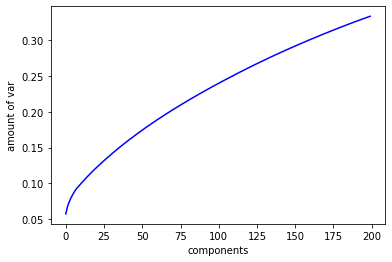

In [19]:
explotter = singularVD.explained_variance_ratio_.cumsum()
plt.plot(explotter,'-', ms = 16, color='blue')
plt.xlabel('components', fontsize= 10)
plt.ylabel('amount of var', fontsize=10)        
plt.show()

In [20]:
simmovie_1= np.array(intermatgen_1_df.loc['Toy Story (1995)']).reshape(1, -1)
simmovie_2 = np.array(intermatgensecdata.loc['Toy Story (1995)']).reshape(1, -1)
conscore = cosine_similarity(intermatgen_1_df, simmovie_1).reshape(-1)
collabscore = cosine_similarity(intermatgensecdata, simmovie_2).reshape(-1)
hybridsim = ((conscore + collabscore)/2.0)
simdic = {'content': conscore , 'collaborative': collabscore, 'hybrid': hybridsim} 
simdf = pd.DataFrame(simdic, index = intermatgen_1_df.index )
simdf.sort_values('content', ascending=False, inplace=True)


In [21]:
simdf[1:].hybrid.head(10)

Toy Story 2 (1999)            0.576069
Bug's Life, A (1998)          0.546659
Ratatouille (2007)            0.573948
Monsters, Inc. (2001)         0.530118
Ice Age (2002)                0.572591
Finding Nemo (2003)           0.515733
Toy Story 3 (2010)            0.572943
Monsters University (2013)    0.470292
Incredibles, The (2004)       0.482902
Up (2009)                     0.501575
Name: hybrid, dtype: float64

<h1>Final Module: Evaluations and Demonstration</h1>

In [22]:
def showprecrec(predrat, k=10, threshold=3.5):
    uet = defaultdict(list)
    for uid, _, true_r, est, _ in predrat:
        uet[uid].append((est, true_r))
    precc = dict()
    recc = dict()
    for uid, urats in uet.items():
        urats.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in urats)
        n_rec_k = sum((est >= threshold) for (est, _) in urats[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in urats[:k])
        precc[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recc[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precc, recc

In [23]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(filtered_ratings[['userId','movieId','rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD()
algo.fit(trainset)
predrat = algo.test(testset)
print(accuracy.rmse(predrat, verbose=True)) # rmse     

RMSE: 0.8414
0.8413599742059105


In [24]:
def recommovie(ui):
    if ui in filtered_ratings.userId.unique():
        listforuser = filtered_ratings[filtered_ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapit.items() if not v in listforuser}        
        predlus = []
        for i, j in d.items():     
            predic = algo.predict(ui, j)
            predlus.append((i, predic[3])) 
        predf = pd.DataFrame(predlus, columns = ['movies', 'ratings'])
        predf.sort_values('ratings', ascending=False, inplace=True)  
        predf.set_index('movies', inplace=True) 
        return predf.head(10)        
    else:
        print("Does not exist")
        return None

In [25]:
recommovie(21496)

,ratings
movies,
2001: A Space Odyssey (1968),4.675870
Fargo (1996),4.665473
Apocalypse Now (1979),4.635525
"Clockwork Orange, A (1971)",4.598192
Citizen Kane (1941),4.573191
Seven Samurai (Shichinin no samurai) (1954),4.520574
Psycho (1960),4.491860
Chinatown (1974),4.481462
Paths of Glory (1957),4.472859


In [26]:
uusers = filtered_ratings.userId.unique()

In [27]:
uusers = uusers[0:50]

In [28]:
uusers
listofusers = uusers.tolist()

In [29]:
pickle.dump(algo, open("hybrid.model", 'wb'))